# Herron Topic 4 - Portfolio Optimization

This notebook covers portfolio optimization.
I have not found a perfect reference that combines portfolio optimization and Python, but here are two references that I find useful:

1. Ivo Welch discusses the mathematics and finance of portfolio optimization in [Chapter 12 of his draft textbook on investments](https://book.ivo-welch.info/bookg.pdf#chapter.12).
1. Eryk Lewinson provides Python code for portfolio optimization in chapter 7 of his [*Python for Finance Cookbook*](https://onesearch.library.northeastern.edu/permalink/01NEU_INST/i2gqis/alma9952082522901401), but he uses several packages that are either non-free or abandoned.

In this notebook, we will:

1. Review the $\frac{1}{n}$ portfolio (or equal-weighted portfolio) from [Herron Topic 1](herron_01_lecture.ipynb)
1. Use SciPy's `minimize()` function to:
    1. Find the minimum variance portfolio
    1. Find the (mean-variance) efficient frontier

In the practice notebook, we will use SciPy's `minimize()` function to achieve any objective.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf

In [2]:
%precision 4
pd.options.display.float_format = '{:.4f}'.format
%config InlineBackend.figure_format = 'retina'

## The $\frac{1}{n}$ Portfolio

We first saw the $\frac{1}{n}$ portfolio (or equal-weighted portfolio) in [Herron Topic 1](herron_01_lecture.ipynb).
In the $\frac{1}{n}$ portfolio, each of $n$ assets receives an equal portfolio weight $w_i = \frac{1}{n}$.
While the $\frac{1}{n}$ strategy seems too simple to be useful, DeMiguel, Garlappi, and Uppal (2007) show that it is difficult to beat $\frac{1}{n}$ strategy, even with more advanced strategies.

In [4]:
tickers = 'MSFT AAPL TSLA AMZN NVDA GOOG'

matana = (
    yf.download(tickers=tickers)
    .rename_axis(columns=['Variable', 'Ticker'])
)

matana.tail()

[*********************100%%**********************]  6 of 6 completed


Variable   Adj Close                                                 Close  \
Ticker          AAPL     AMZN     GOOG     MSFT     NVDA     TSLA     AAPL   
Date                                                                         
2024-03-28  171.4800 180.3800 152.2600 420.7200 903.5600 175.7900 171.4800   
2024-04-01  170.0300 180.9700 156.5000 424.5700 903.6300 175.2200 170.0300   
2024-04-02  168.8400 180.6900 155.8700 421.4400 894.5200 166.6300 168.8400   
2024-04-03  169.6500 182.4100 156.3700 420.4500 889.6400 168.3800 169.6500   
2024-04-04  168.8200 180.0000 151.9400 417.8800 859.0500 171.1100 168.8200   

Variable                               ...     Open                    \
Ticker         AMZN     GOOG     MSFT  ...     GOOG     MSFT     NVDA   
Date                                   ...                              
2024-03-28 180.3800 152.2600 420.7200  ... 152.0000 420.9600 900.0000   
2024-04-01 180.9700 156.5000 424.5700  ... 151.8300 423.9500 902.9900   
2024-04-02 180.6900 155.8700 421.4400  ... 154.7500 420.1100 884.4800   
2024-04-03 182.4100 156.3700 420.4500  ... 154.9200 419.7300 884.8400   
2024-04-04 180.0000 151.9400 417.8800  ... 155.0800 424.9900 904.0600   

Variable               Volume                                            \
Ticker         TSLA      AAPL          AMZN          GOOG          MSFT   
Date                                                                      
2024-03-28 177.4500  65672700 38051600.0000 21105600.0000 21871200.0000   
2024-04-01 176.1700  46240500 29174500.0000 24469800.0000 16316000.0000   
2024-04-02 164.7500  49329500 32611500.0000 17598100.0000 17912000.0000   
2024-04-03 164.0200  47602100 30959800.0000 17218400.0000 16475600.0000   
2024-04-04 170.0700  53582300 41543000.0000 24114800.0000 19330000.0000   

Variable                                 
Ticker              NVDA           TSLA  
Date                                     
2024-03-28 43521200.0000  77654800.0000  
2024-04-01 45244100.0000  81562100.0000  
2024-04-02 43306400.0000 116650600.0000  
2024-04-03 36845000.0000  82578000.0000  
2024-04-04 43300900.0000 122832800.0000  

[5 rows x 36 columns]

In [5]:
returns = (
    matana['Adj Close']
    .iloc[:-1]
    .pct_change()
    .iloc[(-3 * 252):]
)

returns.describe()

Ticker,AAPL,AMZN,GOOG,MSFT,NVDA,TSLA
count,756.0000,756.0000,756.0000,756.0000,756.0000,756.0000
mean,0.0006,0.0005,0.0007,0.0009,0.0031,0.0003
std,0.0169,0.0235,0.0198,0.0173,0.0335,0.0356
min,-0.0587,-0.1405,-0.0963,-0.0772,-0.0947,-0.1224
25%,-0.0085,-0.0123,-0.0097,-0.0081,-0.0161,-0.0194
50%,0.0006,0.0003,0.0010,0.0003,0.0030,0.0014
75%,0.0102,0.0129,0.0110,0.0110,0.0211,0.0190
max,0.0890,0.1354,0.0775,0.0823,0.2437,0.1353


Before we revisit the advanced techniques from [Herron Topic 1](herron_01_lecture), we can calculate $\frac{1}{n}$ portfolio returns manually, where $r_P = \frac{\sum_{i}^{n} r_i}{n}$
Since our weights are constant (i.e., do not change over time), we rebalance our portfolio every return period.
If we have daily data, rebalance daily.
If we have monthly data, we rebalance monthly, and so on.

In [6]:
n = returns.shape[1]
p1 = returns.sum(axis=1).div(n)

p1.describe()

count   756.0000
mean      0.0010
std       0.0195
min      -0.0632
25%      -0.0101
50%       0.0014
75%       0.0121
max       0.0980
dtype: float64

Recall from [Herron Topic 1](herron_01_lecture) we have two better options:

1. The `.mean(axis=1)` method for the $\frac{1}{n}$ portfolio
1. The `.dot(weights)` method where `weights` is a pandas series or NumPy array of portfolio weights, allowing different weights for each asset

In [7]:
p2 = returns.mean(axis=1)

p2.describe()

count   756.0000
mean      0.0010
std       0.0195
min      -0.0632
25%      -0.0101
50%       0.0014
75%       0.0121
max       0.0980
dtype: float64

In [8]:
weights = np.ones(n) / n

weights

array([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])

In [9]:
p3 = returns.dot(weights)

p3.describe()

count   756.0000
mean      0.0010
std       0.0195
min      -0.0632
25%      -0.0101
50%       0.0014
75%       0.0121
max       0.0980
dtype: float64

The `.describe()` method provides summary statistics for data, letting us make quick comparisons.
However, we should use `np.allclose()` if we want to be sure that `p1`, `p2`, and `p3` are similar.

In [10]:
np.allclose(p1, p2)

True

In [11]:
np.allclose(p1, p3)

True

---

Here is a simple example to help understand the `.dot()` method.

In [12]:
silly_n = 3
silly_r = pd.DataFrame(np.arange(2*silly_n).reshape(2, silly_n))
silly_w = np.ones(3) / 3

In [13]:
print(
    f'silly_n:\n{silly_n}',
    f'silly_r:\n{silly_r}',
    f'silly_w:\n{silly_w}',
    sep='\n\n'
)

silly_n:
3

silly_r:
   0  1  2
0  0  1  2
1  3  4  5

silly_w:
[0.3333 0.3333 0.3333]


In [14]:
silly_r.dot(silly_w)

0   1.0000
1   4.0000
dtype: float64

Under the hood, Python and the `.dot()` method (effectively) do the following calculation:

In [15]:
for i, row in silly_r.iterrows():
    print(
        f'Row {i}: ',
        ' + '.join([f'{w:0.2f} * {y}' for w, y in zip(silly_w, row)]),
        ' = ',
        f'{silly_r.dot(silly_w).iloc[i]:0.2f}'
    )

Row 0:  0.33 * 0 + 0.33 * 1 + 0.33 * 2  =  1.00
Row 1:  0.33 * 3 + 0.33 * 4 + 0.33 * 5  =  4.00


---

## SciPy's `minimize()` Function 

### A Crash Course in SciPy's `minimize()` Function

The `minimize()` function from SciPy's `optimize` module finds the input array `x` that minimizes the output of the function `fun`.
The `minimize()` function uses optimization techniques that are outside this course, but you can consider these optimization techniques to be sophisticated trial and error.

Here are the most common arguments we will pass to the `minimize()` function:

1. We pass our first guess for input array `x` to argument `x0=`.
1. We pass additional arguments for function `fun` as a tuple to argument `args=`.
1. We pass lower and upper bounds on `x` as a tuple of tuples to argument `bounds=`.
1. We constrain our results with a tuple of dictionaries of functions to argument `contraints=`.

Here is a simple example that minimizes the function `quadratic()` that accepts arguments `x` and `a` and returns $y = (x - a)^2$.

In [16]:
import scipy.optimize as sco

In [17]:
def quadratic(x, a=5):
    return (x - a) ** 2

In [18]:
quadratic(x=5, a=5)

0

In [19]:
quadratic(x=10, a=5)

25

It is helpful to plot $y = (x - a)$ first.

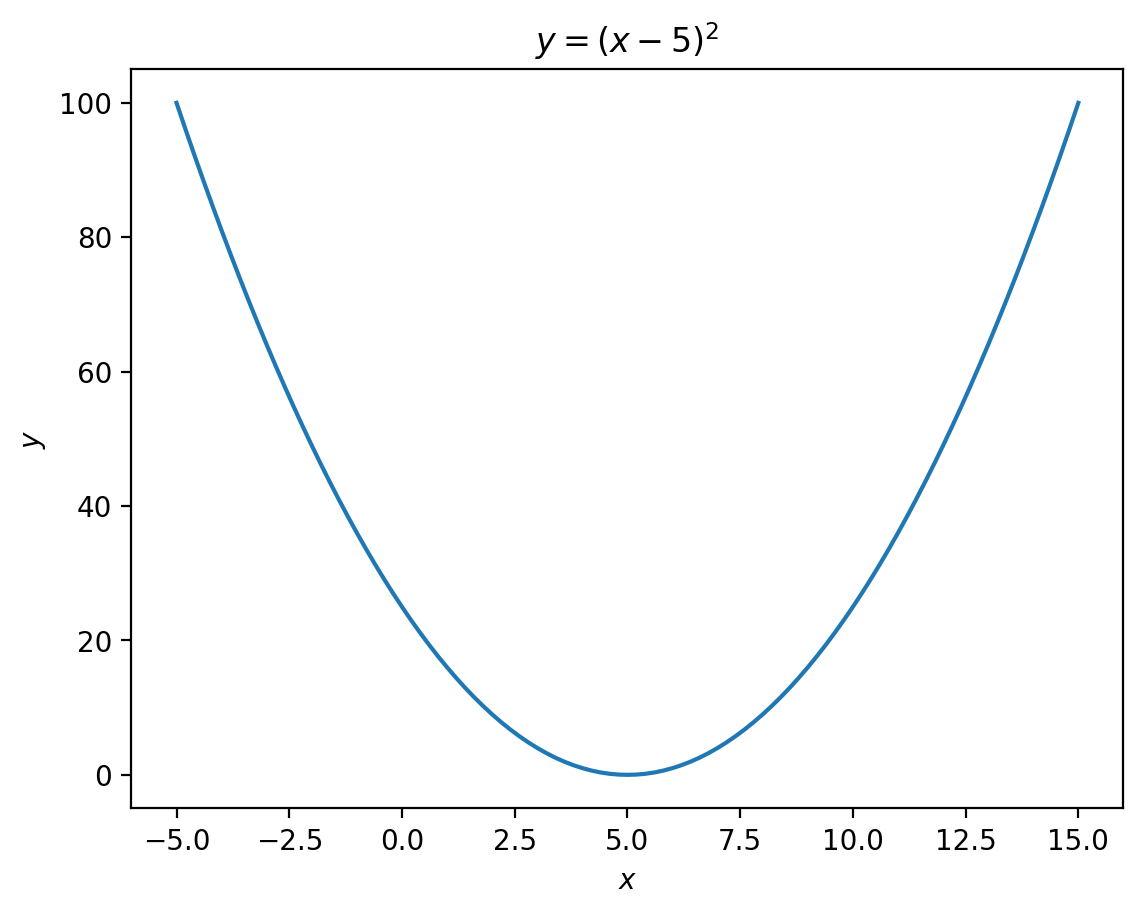

In [20]:
x = np.linspace(-5, 15, 101)
y = quadratic(x=x)
plt.plot(x, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$y = (x - 5)^2$')
plt.show()

The minimum output of `quadratic()` occurs at $x=5$ if we do not use bounds or constraints, even if we start far away from $x=5$.

In [21]:
sco.minimize(
    fun=quadratic,
    x0=np.array([2001])
)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.0392713450495178e-16
        x: [ 5.000e+00]
      nit: 4
      jac: [-1.366e-08]
 hess_inv: [[ 5.000e-01]]
     nfev: 18
     njev: 9

The minimum output of `quadratic()` occurs at $x=6$ if we bound `x` between 6 and 10 (i.e., $6 \leq x \leq 10$).

In [24]:
sco.minimize(
    fun=quadratic,
    x0=np.array([2001]),
    bounds=((6, 10),)
)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 1.0
        x: [ 6.000e+00]
      nit: 1
      jac: [ 2.000e+00]
     nfev: 4
     njev: 2
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

The minimum output of `quadratic()` occurs at $x=6$, again, if we constrain `x - 6` to be non-negative.
We use bounds to limit the search space directly, and we use constraints to limit the search space indirectly based on a formula.

In [25]:
sco.minimize(
    fun=quadratic,
    x0=np.array([2001]),
    constraints=({'type': 'ineq', 'fun': lambda x: x - 6})
)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.0000000000000018
       x: [ 6.000e+00]
     nit: 3
     jac: [ 2.000e+00]
    nfev: 6
    njev: 3

We can use the `args=` argument to pass additional arguments to `fun`.
For example, we change the `a=` argument in `quadratic()` from the default of `a=5` to `a=20` with `args=(20,)`.
Note that `args=` expects a tuple, so we need a trailing comma `,` if we have one argument.

In [26]:
sco.minimize(
    fun=quadratic,
    args=(20,),
    x0=np.array([2001]),
)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 7.090392030754976e-17
        x: [ 2.000e+01]
      nit: 4
      jac: [-1.940e-09]
 hess_inv: [[ 5.000e-01]]
     nfev: 18
     njev: 9

### The Minimum Variance Portfolio

We can find the minimum variance portfolio with `minimize()` function from SciPy's `optimize` module.
The `minimize()` function with vary an input array `x` (starting from argument `x0=`) to minimize the objective function `fun=` subject to the bounds and constraints in `bounds=` and `constraints=`. 
We will define a function `port_vol()` to calculate portfolio volatility.
The first argument to `port_vol()` must be the input array `x` that the `minimize()` function searches over.
For clarity, we will call this first argument `x`, but the argument's name is not important.

In [27]:
def port_vol(x, r, ppy):
    return np.sqrt(ppy) * r.dot(x).std()

We will eventually need a mean portfolio return function, too.

In [28]:
def port_mean(x, r, ppy):
    return ppy * r.dot(x).mean()

In [29]:
[(0,1) for _ in returns]

[(0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

In [30]:
res_mv = sco.minimize(
    fun=port_vol, # objective function that we minimize
    x0=np.ones(returns.shape[1]) / returns.shape[1], # initial portfolio weights are 1/n
    args=(returns, 252), # additional arguments to our objective function
    bounds=[(0,1) for _ in returns], # bounds limit the search space for each portfolio weights
    constraints=(
        {'type': 'eq', 'fun': lambda x: x.sum() - 1} # minimize drives "eq" constraints to zero
    )
)

print(res_mv)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.2501306149875224
       x: [ 5.064e-01  2.776e-17  9.326e-02  4.004e-01  2.082e-17
            6.939e-18]
     nit: 7
     jac: [ 2.506e-01  2.591e-01  2.502e-01  2.496e-01  3.628e-01
            2.920e-01]
    nfev: 49
    njev: 7


What are the attributes of this minimum variance portfolio?

In [31]:
def print_port_res(w, r, title, ppy=252, tgt=None):
    width = len(title)
    rp = r.dot(w)
    mu = ppy * rp.mean()
    sigma = np.sqrt(ppy) * rp.std()
    if tgt is not None:
        er = rp.sub(tgt)
        sr = np.sqrt(ppy) * er.mean() / er.std()
    else:
        sr = None
    
    return print(
        title,
        '=' * width,
        '',
        'Performance',
        '-' * width,
        'Return:'.ljust(width - 6) + f'{mu:0.4f}',
        'Volatility:'.ljust(width - 6) + f'{sigma:0.4f}',
        'Sharpe Ratio:'.ljust(width - 6) + f'{sr:0.4f}\n' if sr is not None else '',
        'Weights', 
        '-' * width, 
        '\n'.join([f'{_r}:'.ljust(width - 6) + f'{_w:0.4f}' for _r, _w in zip(r.columns, w)]),
        sep='\n',
    )

In [32]:
print_port_res(w=res_mv['x'], r=returns, title='Minimum Variance Portfolio')

Minimum Variance Portfolio

Performance
--------------------------
Return:             0.1897
Volatility:         0.2501

Weights
--------------------------
AAPL:               0.5064
AMZN:               0.0000
GOOG:               0.0933
MSFT:               0.4004
NVDA:               0.0000
TSLA:               0.0000


### The Mean-Variance Efficient Frontier

We will use the `minimize()` function to map the efficient frontier.
Here is a basic outline:

1. Create a NumPy array `tret` of target returns
1. Create an empty list `res_ef` of `minimize()` results
1. Loop over `tret`, passing each as a constraint to the `minimize()` function
1. Append each `minimize()` result to `res_ef`

In [33]:
returns.mean()

Ticker
AAPL   0.0006
AMZN   0.0005
GOOG   0.0007
MSFT   0.0009
NVDA   0.0031
TSLA   0.0003
dtype: float64

In [36]:
tret = 252 * np.linspace(returns.mean().min(), returns.mean().max(), 25)

tret

array([0.0675, 0.0968, 0.1262, 0.1555, 0.1849, 0.2143, 0.2436, 0.273 ,
       0.3023, 0.3317, 0.3611, 0.3904, 0.4198, 0.4492, 0.4785, 0.5079,
       0.5372, 0.5666, 0.596 , 0.6253, 0.6547, 0.684 , 0.7134, 0.7428,
       0.7721])

We will loop over these target returns, finding the minimum variance portfolio for each target return.

In [37]:
res_ef = []

for t in tret:
    _ = sco.minimize(
        fun=port_vol, # minimize portfolio volatility
        x0=np.ones(returns.shape[1]) / returns.shape[1], # initial portfolio weights of 1/n
        args=(returns, 252), # additional arguments to fun, in order
        bounds=[(0, 1) for c in returns.columns], # bounds limit the search space for each portfolio weight
        constraints=(
            {'type': 'eq', 'fun': lambda x: x.sum() - 1}, # constrain sum of weights to one
            {'type': 'eq', 'fun': lambda x: port_mean(x=x, r=returns, ppy=252) - t} # constrains portfolio mean return to the target return
        )
    )
    res_ef.append(_)

List `res_ef` contains the results of all 25 minimum-variance portfolios.
For example, `res_ef[0]` is the minimum variance portfolio for the lowest target return.

In [39]:
returns.columns

Index(['AAPL', 'AMZN', 'GOOG', 'MSFT', 'NVDA', 'TSLA'], dtype='object', name='Ticker')

In [38]:
res_ef[0]

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.5658612930635905
       x: [ 0.000e+00  1.206e-10  0.000e+00  1.775e-16  0.000e+00
            1.000e+00]
     nit: 3
     jac: [ 1.383e-01  1.648e-01  1.271e-01  1.179e-01  2.690e-01
            5.659e-01]
    nfev: 21
    njev: 3

I typically check that all portfolio volatility minimization succeeds.
If a portfolio volatility minimization fails, we should check our function, bounds, and constraints.

In [40]:
for r in res_ef:
    assert r['success'] 

We can combine the target returns and volatilities into a data frame `ef`.

In [41]:
ef = pd.DataFrame(
    {
        'tret': tret,
        'tvol': np.array([r['fun'] if r['success'] else np.nan for r in res_ef])
    }
)

ef.head()

,tret,tvol
0,0.0675,0.5659
1,0.0968,0.3984
2,0.1262,0.2974
3,0.1555,0.2597
4,0.1849,0.2504


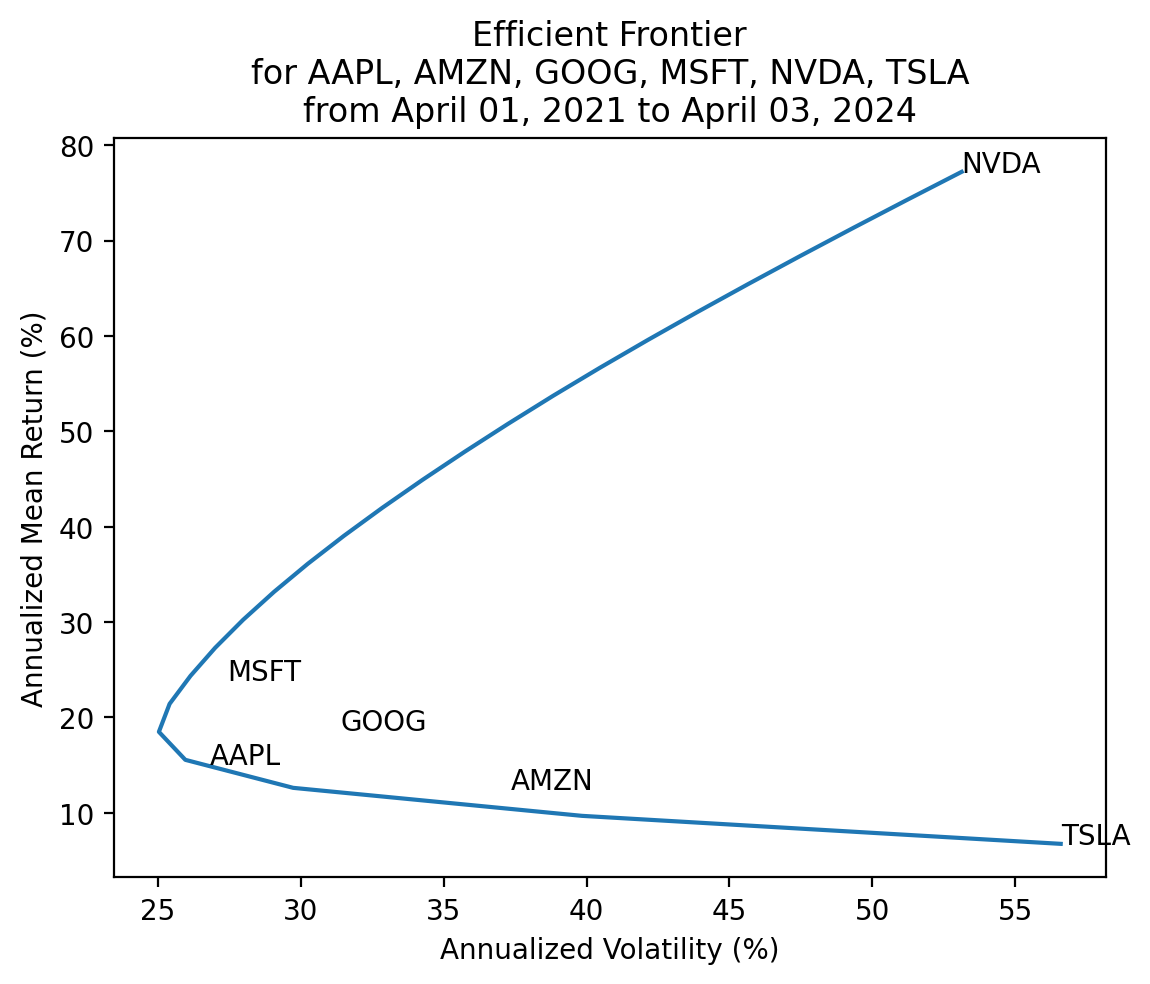

In [42]:
ef.mul(100).plot(x='tvol', y='tret', legend=False)
plt.ylabel('Annualized Mean Return (%)')
plt.xlabel('Annualized Volatility (%)')
plt.title(
    f'Efficient Frontier' +
    f'\nfor {", ".join(returns.columns)}' +
    f'\nfrom {returns.index[0]:%B %d, %Y} to {returns.index[-1]:%B %d, %Y}'
)

for t, x, y in zip(
    returns.columns, 
    returns.std().mul(100*np.sqrt(252)),
    returns.mean().mul(100*252)
):
    plt.annotate(text=t, xy=(x, y))
    
plt.show()